# Map Matching Project - Phase 1
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi - Hamidreza Yaghoubi - Alireza Heidari - Reza Vahidi Majd - Parham Rezaei<h3>
<h3 style = "color: cyan"> Documents Designed by: Mohammad Moshtaghi Far<h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase1.ipynb or .zip </h5>
</div>

Setting up the environment

In [1]:
%pip install pyrosm keplergl haversine pandas numpy


     ---------------------------------------- 2.5/2.5 MB 84.8 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 9.7/9.7 MB 252.0 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): start

In [1]:
import datetime
import numpy as np
import pandas as pd
import pyrosm
import random
import ssl
import time

from keplergl import KeplerGl
from pyrosm import OSM, get_data

In [ ]:
# If you are using colab, you need to run this cell
from google.colab import output
output.enable_custom_widget_manager()

## Introduction
In this phase of project, you are going to implement a *denoising algorithm*. In many cases, when an application is dealing with _user GPS location_, in many urban areas and the places with tall towers, the GPS signal gets too noisy! This is the reason of why when you open "google maps", you see your current location with a blue circle around it. The radius of this circle shows the accuracy of your location. Sometimes, this radius is around 10m and in other areas, it goes in scale of km, making the GPS location totally unstable and unreliable! This amount of noise makes it impossible to use the data for any kind of analysis. In "ride hailing" applications like Uber, many of functionalities rely on the accuracy of GPS data. E.g. ETA estimation (Estimated time of arrival) is highly dependent on the accuracy of GPS data. In this phase, you are going to implement a denoising algorithm to make the GPS data more reliable. You will use your kowledge of Hidden Markov Models to implement this algorithm.

<div style="text-align: center">
<img src="./Images/blue_dot.jpg" height="500" width="auto" /> </br>
(Sample of GPS data with blue dot)
</div>

# Loading Pasdaran streets dataset

In this section, you will load a dataset that is prepared for you. The dataset contains some GPS locations (nodes) from Pasdaran Streets and also another dataset which contains the "streets" in Pasdaran area. By "street" we mean a pair of nodes, representing two end-points of a street in the map. These datasets are in `Data/` folder with names `pasdaran_streets.csv` and `pasdaran_nodes.csv`.

In [2]:
# Load the data
pasdaran_streets = pd.read_csv('pasdaran_streets.csv')
pasdaran_nodes = pd.read_csv('pasdaran_nodes.csv')

In [3]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


In [4]:
pasdaran_nodes.head()

,id,lat,lon
0,423833948,35.772419,51.465652
1,423793584,35.771748,51.465084
2,177536927,35.776230,51.465034
3,177540293,35.771034,51.464462
4,423832815,35.772175,51.461494


In [5]:
# Visualize pasdaran_streets using kepler
street_map = KeplerGl()
street_map.add_data(data=pasdaran_streets, name='pasdaran_streets')
street_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'pasdaran_streets': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

# Creating dataset for trip

As you understood, until now, we loaded 2 datasets, `pasdaran_nodes` and `pasdaran_streets`. Now, we should create a dataset from these, such that we can use it for our trip. Each item in this dataset is called a `ride`. We will explain more as we go on.

First, we should create a **trip** for a driver. For this sake, we should choose 2 random points in our map as the source and destination of the trip. Now, we should find the streets that connect these 2 points. Each street has a length. You should find the shortest path between these 2 points (source and destination) which are in the `pasdaran_streets`. Note that this path should be the **shortest path** meaning that the sum of the lengths of streets should be minimum.

**NOTE**: You cannot use any library for finding the shortest path. You should implement it yourself, from scratch. Feel free to use any algorithm and heuristic that you want. Be creative!

**NOTE**: Be aware of "length of streets" and whether or not they are "one_way"!

In [6]:
# TODO: You should implement this from scratch and you cannot use any library (such as networkx) for finding the shortest path.
from math import radians, sin, cos, sqrt, atan2

def find_shotest_path(start_node, end_node, graph):
    """
    Find the shortest path between two nodes in a graph.
    :param start_node: The start node
    :param end_node: The end node
    :param graph: The graph
    :return: The shortest path. It is a list of node_ids from start_node to end_node.
    Note that you use all of the data in "pasdaran_streets" dataset appropriately such as "street_length" and "one_way".
    """
    # TODO
    df = pd.DataFrame(graph)
    another_graph = {}
    for index, row in df.iterrows():
        if row['u'] not in another_graph:
            another_graph[row['u']] = {}
        if row['v'] not in another_graph:
            another_graph[row['v']] = {}
        another_graph[row['u']][row['v']] = row['length']
        another_graph[row['v']][row['u']] = row['length']
    another_start_node, _ = find_closest_node(start_node[0], start_node[1], df)
    another_end_node, _ = find_closest_node(end_node[0], end_node[1], df)
    shortest_path = dijkstra(another_graph, another_start_node, another_end_node)
    
    return shortest_path


def dijkstra(graph, start, end):
    shortest_distances = {node: float('inf') for node in graph}
    shortest_distances[start] = 0
    visited = set()
    previous_nodes = {}
    while visited != set(shortest_distances):
        current_node = min (
            {node: shortest_distances[node] for node in shortest_distances if node not in visited},
            key=shortest_distances.get
        )
        visited.add(current_node)
        for neighbor, weight in graph[current_node].items():
            if weight + shortest_distances[current_node] < shortest_distances[neighbor]:
                shortest_distances[neighbor] = weight + shortest_distances[current_node]
                previous_nodes[neighbor] = current_node
    path = []
    each_distance = []
    while end is not None:
        path.append(end)
        each_distance.append(shortest_distances[end])
        end = previous_nodes.get(end)
        
    if shortest_distances[path[-1]] != float('inf'):
        return path[::-1], each_distance[::-1]
    return None, None


def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    return distance


def find_closest_node(lat, lon, df):
    closest_node = None
    closest_distance = float('inf')
    for index, row in df.iterrows():
        distance = calculate_distance(lat, lon, row['u_lat'], row['u_lon'])
        if distance < closest_distance:
            closest_distance = distance
            closest_node = row['u']
            
    return closest_node, closest_distance

You should **upload** this cell (`find_shortest_path` function) as a .py file to quera. Your code will be verified if it is actually finding the shortest path and only if it's correct, you will get the grades of this section. Be sure that you put the approriate `import ...` statements at the first of your `.py` file. Remember, you **can not** use any library that does the "shortest path" for you. (like networkx) You should implement it yourself.

**Note**: You can add other functions and codes to above cell, but you code should have the `find_shortest_path` function with exactly same signature that we have provided. Your code will be tested with calling this function. So, using other functions is not a problem, but keep in mind that the main entry for your code when we test it is the `find_shortest_path` function. Nothing else!

In [9]:
# Create a trip: Choose 2 random points as start and end points and find the shortest path between them.
# A trip is a list of node_ids from start_node to end_node.

# TODO: Implement and print out a sample trip

import random

def get_random_node(df):
    return df.iloc[random.randint(0, df.shape[0])]

def extract_lat_lon(node):
    return [node['lat'], node['lon']]

start_node = get_random_node(pasdaran_nodes)
end_node = get_random_node(pasdaran_nodes)

print("start : ", start_node)
print("end : ", end_node)

start_coords = extract_lat_lon(start_node)
end_coords = extract_lat_lon(end_node)

path, distance = find_shotest_path(start_coords, end_coords, pasdaran_streets)

print(path)

start :  id     4.548912e+09
lat    3.577279e+01
lon    5.144461e+01
Name: 835, dtype: float64
end :  id     4.698557e+09
lat    3.577935e+01
lon    5.146010e+01
Name: 394, dtype: float64
[4548912081, 4695866628, 4548912084, 4695866626, 423813732, 423813733, 4695998342, 4698385298, 4316456837, 423815715, 4316456853, 4316456851, 423816018, 423816019, 4316456858, 4695998355, 4551688565, 423815693, 423815694, 4698536184, 423815692, 423815695, 423832812, 423832813, 4698544220, 4698544218, 4695975713, 423793661, 4695969098, 806589258, 1707151175, 423793624, 6096557785, 10922701617, 10922701619, 10922701618, 6096557786, 6434310435, 6434310436, 4698557156, 423793665, 423793666, 4698557154, 4698557152]


Visualize the sampled trip (in the previous cell) on the map. Use `kepler` library for this purpose. Notice that you use keplers "timestep" attributes to create a timeline, so you can see the trip's process from _start\_node_ to _end\_node_. (You can see an output sample in the next cell)

In [10]:
#TODO: Visualize the sampled trip using kepler
node_distance = {node: distance for node, distance in zip(path, distance)}

path_nodes = pasdaran_nodes[pasdaran_nodes['id'].isin(path)]
path_nodes['distance'] = path_nodes['id'].map(node_distance)
trip_map = KeplerGl()
trip_map.add_data(data=path_nodes, name='data_1')
trip_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\KASRA\AppData\Local\Temp\ipykernel_19344\2457319822.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path_nodes['distance'] = path_nodes['id'].map(node_distance)


KeplerGl(data={'data_1': {'index': [51, 91, 137, 138, 139, 140, 149, 154, 157, 387, 388, 389, 390, 391, 392, 3…

Now, we are going to get the points in the middle of the streets. Before, we only had the intersections of the streets(start and end nodes of a section). But we know in real life, we get gps locations also in between and not necessarily in the intersections. So, we should add these points to our data. We call every entity of this type as `Ride`. A ride is defined by 3 parameters:
1. `ride_speed`: The speed of the ride which driver is driving with. We assume that the driver is driving with a constant speed.
2. `driver_gps_time`: The time interval that the driver sends his/her gps location to the server. (e.g. every 5 seconds)
3. `trip`: The specific trip that the driver is driving in. (we created this in the previous cells)

Now, you should define a function that gets these parameters and returns the locations (lat/longs) in the ride regarding the given parameters.

In [11]:
def visualize_a_ride(ride_speed, ride_gps_time, trip, distance):
    ride = []

    ride.append(get_node_coordinates(trip[0]))
    current_distance = 0
    current_index = 1

    while current_distance < distance[-1]:
        current_distance += ride_speed * ride_gps_time
        while current_distance > distance[current_index]:
            current_index += 1
            if current_index >= len(distance):
                return ride

        street_length = distance[current_index] - distance[current_index - 1]
        part_length = current_distance - distance[current_index - 1]
        ratio = part_length / street_length

        start_lat, start_lon = get_node_coordinates(trip[current_index - 1])
        end_lat, end_lon = get_node_coordinates(trip[current_index])

        new_lat = interpolate_coordinates(start_lat, end_lat, ratio)
        new_lon = interpolate_coordinates(start_lon, end_lon, ratio)
        ride.append([new_lat, new_lon])

    return ride


def interpolate_coordinates(start, end, ratio):
    return start + ratio * (end - start)

def get_node_coordinates(node_id):
    node = pasdaran_nodes[pasdaran_nodes['id'] == node_id].iloc[0]
    return node['lat'], node['lon']

See a sample ride, printed out.

In [12]:
#TODO
#trip = [1721683025, 423815697, 423815691, 423815693, 5667400230, 2918357569]
ride = visualize_a_ride(12, 5, path, distance)
print(ride)

[(35.772789001464844, 51.44460678100586), [35.7729282377213, 51.44524812422288], [35.773302660208785, 51.44560181708021], [35.77380768775467, 51.44583601799345], [35.774313459600194, 51.44606777146279], [35.774819236560504, 51.446299515421195], [35.775325185709455, 51.446530677265756], [35.77583329216665, 51.44675454595234], [35.77595966240771, 51.44720387458984], [35.775782876425204, 51.44783225248803], [35.775864187978726, 51.448310362433105], [35.77637366475252, 51.44852943089003], [35.77688105102085, 51.44875557346131], [35.77738540432962, 51.4489919890748], [35.77789165480827, 51.44922214140072], [35.778181763617496, 51.44966261181065], [35.778248745537844, 51.45032257693838], [35.77831532043438, 51.45098260277447], [35.77837997881146, 51.45164291019851], [35.778457013535125, 51.452301206928006], [35.778524345092684, 51.45296095273423], [35.77857697649799, 51.453622893870104], [35.77852051581367, 51.454271117793446], [35.77836055423521, 51.45490632753979], [35.77818730494758, 51.4

Visualize the sample ride on the map using `kepler` library. You should define an animation based on the order of the points in the ride, so you can play the animation in the visualization and see the ride!

In [13]:
#TODO: Visualize the sampled ride using kepler
ride_data = pd.DataFrame(ride, columns=['lat', 'lon'])
ride_map = KeplerGl()
ride_map.add_data(data=ride_data, name='ride_data')
ride_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride_data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…

Now, to complete our dataset, we need to put some random noise on the gps locations. For this sake, we easily add some random noise to the lat/longs of a created `ride`. You should define a function that gets a `ride` and adds some random noise to the lat/longs of the ride. Your function should take in 2 parameters: _ride_ and _gps\_noise\_radius_ which is the radius of the circle that you want to add noise to the gps locations. (e.g. 10 meters). The gps noise in assumed to be a normal distribution. So, assume `standard deviation` of the noise to be `gps_noise_radius`.

In [14]:
# put a random noise on each (lat, lon) location to simulate the GPS noise (suppoes GPS radius is 3 - 8 meters)
# TODO
# Print out a sample
import math

min_radius = 0.000027 # eq to 3 meters
max_radius = 0.000073 # eq to 8 meters

def add_uniform_gps_noise(ride, gps_noise_radius):
    noisy_ride = []
    for lat, lon in ride:
        uniform_lat_noise = random.uniform(-gps_noise_radius, gps_noise_radius)
        uniform_lon_noise = random.uniform(-gps_noise_radius, gps_noise_radius)
        
        noisy_lat_uniform = lat + uniform_lat_noise
        noisy_lon_uniform = lon + uniform_lon_noise
        
        noisy_ride.append((noisy_lat_uniform, noisy_lon_uniform))
    return noisy_ride

def add_normal_gps_noise(ride, gps_noise_radius):
    noisy_ride = []
    for lat, lon in ride:
        normal_lat_noise = random.gauss(0, gps_noise_radius)
        normal_lon_noise = random.gauss(0, gps_noise_radius)
        
        noisy_lat_normal = lat + normal_lat_noise
        noisy_lon_normal = lon + normal_lon_noise
        
        noisy_ride.append((noisy_lat_normal, noisy_lon_normal))
    return noisy_ride

def add_mixed_gps_noise(ride, gps_noise_radius):
    noisy_ride = []
    for lat, lon in ride:
        normal_lat_noise = random.gauss(0, gps_noise_radius)
        normal_lon_noise = random.gauss(0, gps_noise_radius)
        
        noisy_lat_normal = lat + normal_lat_noise
        noisy_lon_normal = lon + normal_lon_noise

        uniform_lat_noise = random.uniform(-gps_noise_radius, gps_noise_radius)
        uniform_lon_noise = random.uniform(-gps_noise_radius, gps_noise_radius)
        
        noisy_lat_uniform = lat + uniform_lat_noise
        noisy_lon_uniform = lon + uniform_lon_noise

        exp_lat_noise = random.expovariate(1/gps_noise_radius)
        exp_lon_noise = random.expovariate(1/gps_noise_radius)
        
        noisy_lat_exp = lat + exp_lat_noise
        noisy_lon_exp = lon + exp_lon_noise

        noisy_lat_combined = (noisy_lat_normal + noisy_lat_uniform + noisy_lat_exp) / 3
        noisy_lon_combined = (noisy_lon_normal + noisy_lon_uniform + noisy_lon_exp) / 3
        
        noisy_ride.append((noisy_lat_combined, noisy_lon_combined))
    
    return noisy_ride


gps_noise_radius = 0.000091 # eq to 10 meters
print("Original Ride:")
for i, position in enumerate(ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")
# normal distribution
noisy_ride = add_normal_gps_noise(ride, gps_noise_radius)
print("\nNormal Noisy Ride:")
for i, position in enumerate(noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")
# uniform distribution
noisy_ride = add_uniform_gps_noise(ride, gps_noise_radius)
print("\nUniform Noisy Ride:")
for i, position in enumerate(noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")
# mixed distribution
noisy_ride = add_mixed_gps_noise(ride, gps_noise_radius)
print("\nMixed Noisy Ride:")
for i, position in enumerate(noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")


Original Ride:
1. Lat: 35.772789001464844, Lon: 51.44460678100586
2. Lat: 35.7729282377213, Lon: 51.44524812422288
3. Lat: 35.773302660208785, Lon: 51.44560181708021
4. Lat: 35.77380768775467, Lon: 51.44583601799345
5. Lat: 35.774313459600194, Lon: 51.44606777146279
6. Lat: 35.774819236560504, Lon: 51.446299515421195
7. Lat: 35.775325185709455, Lon: 51.446530677265756
8. Lat: 35.77583329216665, Lon: 51.44675454595234
9. Lat: 35.77595966240771, Lon: 51.44720387458984
10. Lat: 35.775782876425204, Lon: 51.44783225248803
11. Lat: 35.775864187978726, Lon: 51.448310362433105
12. Lat: 35.77637366475252, Lon: 51.44852943089003
13. Lat: 35.77688105102085, Lon: 51.44875557346131
14. Lat: 35.77738540432962, Lon: 51.4489919890748
15. Lat: 35.77789165480827, Lon: 51.44922214140072
16. Lat: 35.778181763617496, Lon: 51.44966261181065
17. Lat: 35.778248745537844, Lon: 51.45032257693838
18. Lat: 35.77831532043438, Lon: 51.45098260277447
19. Lat: 35.77837997881146, Lon: 51.45164291019851
20. Lat: 35.778

### Different noise models
Experiment adding noise to rides using different models (PDFs) of noise. For example, you can use a uniform distribution for noise. Or you can use a normal distribution for noise. Or you can use a mixture of different distributions. You can also use a distribution that is dependent on the speed of the ride.
1. Visualize each noise model (PDF) on a plot. (You can use `matplotlib` library for this purpose)
2. Visualize the rides with different noise models on the map. (You can use `kepler` library for this purpose)
3. Compare the results of different noise models. Which one is more descriptive of the real world? Why?
4. Choose one model that you find appropriate for training your HMM on it. We will use that model for the rest of the project.

In [15]:
#TODO: Experimenting with different GPS noise radiuses
gps_noise_radius = random.uniform(min_radius, max_radius)
print("First for this radius: ", gps_noise_radius)
# normal distribution
random_normal_noisy_ride = add_normal_gps_noise(ride, gps_noise_radius)
print("\nNormal Noisy Ride:")
for i, position in enumerate(random_normal_noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")
# uniform distribution
random_uniform_noisy_ride = add_uniform_gps_noise(ride, gps_noise_radius)
print("\nUniform Noisy Ride:")
for i, position in enumerate(random_uniform_noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")
# mixed distribution
random_mixed_noisy_ride = add_mixed_gps_noise(ride, gps_noise_radius)
print("\nMixed Noisy Ride:")
for i, position in enumerate(random_mixed_noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")

# once again for min radius:

gps_noise_radius = 0.000030
print("\nOnce again for this radius: ", gps_noise_radius)
# normal distribution
min_normal_noisy_ride = add_normal_gps_noise(ride, gps_noise_radius)
print("\nNormal Noisy Ride:")
for i, position in enumerate(min_normal_noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")
# uniform distribution
min_uniform_noisy_ride = add_uniform_gps_noise(ride, gps_noise_radius)
print("\nUniform Noisy Ride:")
for i, position in enumerate(min_uniform_noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")
# mixed distribution
min_mixed_noisy_ride = add_mixed_gps_noise(ride, gps_noise_radius)
print("\nMixed Noisy Ride:")
for i, position in enumerate(min_mixed_noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")
    
# once again for max radius:

gps_noise_radius = 0.000070
print("\nOnce again for this radius: ", gps_noise_radius)
# normal distribution
max_normal_noisy_ride = add_normal_gps_noise(ride, gps_noise_radius)
print("\nNormal Noisy Ride:")
for i, position in enumerate(max_normal_noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")
# uniform distribution
max_uniform_noisy_ride = add_uniform_gps_noise(ride, gps_noise_radius)
print("\nUniform Noisy Ride:")
for i, position in enumerate(max_uniform_noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")
# mixed distribution
max_mixed_noisy_ride = add_mixed_gps_noise(ride, gps_noise_radius)
print("\nMixed Noisy Ride:")
for i, position in enumerate(max_mixed_noisy_ride, start=1):
    print(f"{i}. Lat: {position[0]}, Lon: {position[1]}")


First for this radius:  5.101314059654478e-05

Normal Noisy Ride:
1. Lat: 35.77281389078275, Lon: 51.444543464529985
2. Lat: 35.77289455564882, Lon: 51.44519782473134
3. Lat: 35.77326971021472, Lon: 51.44554537420229
4. Lat: 35.77380595857432, Lon: 51.445907252906494
5. Lat: 35.77429890277587, Lon: 51.44596608897067
6. Lat: 35.774824701983086, Lon: 51.44642146972001
7. Lat: 35.77527126502538, Lon: 51.446609456495075
8. Lat: 35.77588550178957, Lon: 51.446745525967295
9. Lat: 35.77587299184772, Lon: 51.44726612978946
10. Lat: 35.77570420274456, Lon: 51.44788443016028
11. Lat: 35.77579868931252, Lon: 51.448298645730056
12. Lat: 35.77635382100568, Lon: 51.448655847680286
13. Lat: 35.77693318449233, Lon: 51.448641156292524
14. Lat: 35.77738365979225, Lon: 51.448984599889755
15. Lat: 35.77783335288815, Lon: 51.44935744293494
16. Lat: 35.77829365666774, Lon: 51.44968444660898
17. Lat: 35.778309713260875, Lon: 51.45036354241728
18. Lat: 35.77834509598671, Lon: 51.45095150814783
19. Lat: 35.778

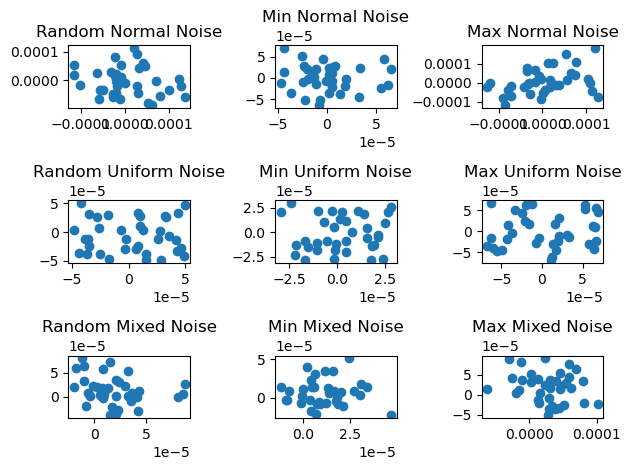

In [16]:
#TODO: Visualize the noise models using matplotlib
import matplotlib.pyplot as plt

# Prepare noisy ride data
plot_x_normal = [[], [], []]
plot_y_normal = [[], [], []]
plot_x_uniform = [[], [], []]
plot_y_uniform = [[], [], []]
plot_x_mixed = [[], [], []]
plot_y_mixed = [[], [], []]

# Extract differences in coordinates
for i in range(len(ride)):
    # normal dist.
    plot_x_normal[0].append(random_normal_noisy_ride[i][1] - ride[i][1])
    plot_y_normal[0].append(random_normal_noisy_ride[i][0] - ride[i][0])
    plot_x_normal[1].append(min_normal_noisy_ride[i][1] - ride[i][1])
    plot_y_normal[1].append(min_normal_noisy_ride[i][0] - ride[i][0])
    plot_x_normal[2].append(max_normal_noisy_ride[i][1] - ride[i][1])
    plot_y_normal[2].append(max_normal_noisy_ride[i][0] - ride[i][0])
    # uniform dist.
    plot_x_uniform[0].append(random_uniform_noisy_ride[i][1] - ride[i][1])
    plot_y_uniform[0].append(random_uniform_noisy_ride[i][0] - ride[i][0])
    plot_x_uniform[1].append(min_uniform_noisy_ride[i][1] - ride[i][1])
    plot_y_uniform[1].append(min_uniform_noisy_ride[i][0] - ride[i][0])
    plot_x_uniform[2].append(max_uniform_noisy_ride[i][1] - ride[i][1])
    plot_y_uniform[2].append(max_uniform_noisy_ride[i][0] - ride[i][0])
    # mixed dist.
    plot_x_mixed[0].append(random_mixed_noisy_ride[i][1] - ride[i][1])
    plot_y_mixed[0].append(random_mixed_noisy_ride[i][0] - ride[i][0])
    plot_x_mixed[1].append(min_mixed_noisy_ride[i][1] - ride[i][1])
    plot_y_mixed[1].append(min_mixed_noisy_ride[i][0] - ride[i][0])
    plot_x_mixed[2].append(max_mixed_noisy_ride[i][1] - ride[i][1])
    plot_y_mixed[2].append(max_mixed_noisy_ride[i][0] - ride[i][0])
# Create subplots and plot the data
fig, axs = plt.subplots(3, 3)
# normal
axs[0, 0].scatter(plot_x_normal[0], plot_y_normal[0])
axs[0, 0].set_title('Random Normal Noise')

axs[0, 1].scatter(plot_x_normal[1], plot_y_normal[1])
axs[0, 1].set_title('Min Normal Noise')

axs[0, 2].scatter(plot_x_normal[2], plot_y_normal[2])
axs[0, 2].set_title('Max Normal Noise')

# uniform
axs[1, 0].scatter(plot_x_uniform[0], plot_y_uniform[0])
axs[1, 0].set_title('Random Uniform Noise')

axs[1, 1].scatter(plot_x_uniform[1], plot_y_uniform[1])
axs[1, 1].set_title('Min Uniform Noise')

axs[1, 2].scatter(plot_x_uniform[2], plot_y_uniform[2])
axs[1, 2].set_title('Max Uniform Noise')

# mixed
axs[2, 0].scatter(plot_x_mixed[0], plot_y_mixed[0])
axs[2, 0].set_title('Random Mixed Noise')

axs[2, 1].scatter(plot_x_mixed[1], plot_y_mixed[1])
axs[2, 1].set_title('Min Mixed Noise')

axs[2, 2].scatter(plot_x_mixed[2], plot_y_mixed[2])
axs[2, 2].set_title('Max Mixed Noise')

fig.tight_layout()
plt.show()

In [18]:
#TODO: Visualize the noise models using kepler
noise_map = KeplerGl()

data_ride = pd.DataFrame(ride, columns=['lat', 'lon'])

# normal
data_normal = pd.DataFrame(random_normal_noisy_ride, columns=['lat', 'lon'])

# uniform
data_uniform = pd.DataFrame(random_uniform_noisy_ride, columns=['lat', 'lon'])

# mixed
data_mixed = pd.DataFrame(random_mixed_noisy_ride, columns=['lat', 'lon'])

noise_map.add_data(data_ride, 'ride')
noise_map.add_data(data_normal, 'normal')
noise_map.add_data(data_uniform, 'uniform')
noise_map.add_data(data_mixed, 'mixed')
noise_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

In [ ]:
#TODO: Choose the best model (while you explain why you chose it)

**Explanation of my noise model:**

I chosed the mixed distribution becasue in real life noises are not uniform, they may differ in different places based on various conditions. Moreover, normal noises may contain some random data that doesn't fit the real expectations, so using a mixed distribution we could have a reasonable noise distribution that is most similar to real world scenarios

Visualize a sample `ride` and its corresponding `noisy_ride` (using your selected noise model) on the map.

In [23]:
#TODO: Visualize using kepler
best_noise_map = KeplerGl()

data_ride = pd.DataFrame(ride, columns=['lat', 'lon'])

# normal
data_normal = pd.DataFrame(random_normal_noisy_ride, columns=['lat', 'lon'])

best_noise_map.add_data(data_ride, 'ride')
best_noise_map.add_data(data_normal, 'normal')
best_noise_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

Now, we create our dataset, We create 20 noisy_rides for each trip.

In [51]:
#TODO: create and store 20 noisy_rides as a dataset for our HMM to train on it and experiment with it
noisy_rides = []
for i in range(20):
    gps_noise_radius = random.uniform(min_radius, max_radius)
    noisy_rides.append(add_mixed_gps_noise(ride, gps_noise_radius))

# HMM

In this section, we want to use the dataset that we created in the previous section to train an HMM model. We want to use HMM models to  **denoise** the gps locations of the rides. We assume that the gps locations of the rides are noisy and we want to denoise them using HMM models. The observations in each _timestamp_ are the observed noisy points in the dataset.

You should implement a class (or function) named HMM which gets the noisy observations and the `streets` of the map (of course, this is not noisy. we saw that as `pasdaran_streets` in the previous section). You should calculate the transition matrix and emission matrix of the HMM model. You should also implement the `viterbi` algorithm to find the most probable sequence of hidden states (which are the points in the streets) given the noisy observations. Finally, your implementation should be capable of returning the denoised gps locations of the rides. Note that how you define your features, and your states. Be creative!

In [25]:
!pip install scikit-spatial

     -------------------------------------- 48.4/48.4 kB 406.2 kB/s eta 0:00:00


In [68]:
#TODO: Implement helper functions for your calculations
from haversine import haversine
import numpy as np
from skspatial.objects import Line

def project_point_to_street(observation, street):
    
    u_lat = street['u_lat']
    u_lon = street['u_lon']
    v_lat = street['v_lat']
    v_lon = street['v_lon']
    one_lat = 111320
    one_lon = (np.cos(35.7768) / 360) * 40075000

    point = [one_lat * (v_lat - u_lat), one_lon * (v_lon - u_lon)]
    another_point = [one_lat * (observation[0] - u_lat), one_lon * (observation[1] - u_lon)]

    line = Line.from_points(point_a = [0, 0], point_b = point)
    final_point = line.project_point(another_point)

    return [(final_point[0] / one_lat) + u_lat, (final_point[1] / one_lon) + u_lon]


def distance_observation_from_street(observation, street):
    u_lat = street['u_lat']
    u_lon = street['u_lon']
    v_lat = street['v_lat']
    v_lon = street['v_lon']
    one_lat = 111320
    one_lon = (np.cos(35.7768) / 360) * 40075000

    point = [one_lat * (v_lat - u_lat), one_lon * (v_lon - u_lon)]
    another_point = [one_lat * (observation[0] - u_lat), one_lon * (observation[1] - u_lon)]

    distance_point_from_mid = (np.linalg.norm(np.cross(point, another_point)) / np.linalg.norm(point)) / 1250

    return distance_point_from_mid




In [ ]:
# Define your HMM model
# Hint: You can assume states of your HMM model to be streets of the map. You may use other designs as well (based on your creativity)!

In [69]:
# Use Viterbi Algorithm to find the most probable set of points (denoised points)
from typing import List
import numpy as np

def viterbi_algorithm(noisy_ride, pasdaran_streets):
    num_time_steps = len(noisy_ride)
    MAX_BEST_STREETS = 9
    
    state_probabilities = [[[0.0, 0] for _ in range(MAX_BEST_STREETS)] for _ in range(num_time_steps)]
    best_previous_states = [[0 for _ in range(MAX_BEST_STREETS)] for _ in range(num_time_steps)]

    for time_step in range(num_time_steps):
        distances = calculate_distances(noisy_ride[time_step], pasdaran_streets)
        sorted_indices = np.argsort(distances)
        probabilities = calculate_probabilities(distances, sorted_indices, MAX_BEST_STREETS)

        for street_idx in range(MAX_BEST_STREETS):
            state_probabilities[time_step][street_idx][1] = sorted_indices[street_idx]

            if time_step != 0:
                best_previous_states[time_step][street_idx] = calculate_best_previous_state(
                    time_step, street_idx, state_probabilities, pasdaran_streets, MAX_BEST_STREETS
                )
                max_probability = calculate_max_probability(
                    time_step, street_idx, best_previous_states, state_probabilities, pasdaran_streets
                )
                state_probabilities[time_step][street_idx][0] = max_probability * probabilities[street_idx]
            else:
                state_probabilities[time_step][street_idx][0] = probabilities[street_idx]

    max_probability = float('-inf')
    best_path_pointer = 0

    for street in range(MAX_BEST_STREETS):
        current_probability = state_probabilities[-1][street][0]
        if current_probability > max_probability:
            max_probability = current_probability
            best_path_pointer = street

    most_probable = [project_point_to_street(noisy_ride[-1], pasdaran_streets.iloc[state_probabilities[-1][best_path_pointer][1]])]

    for time_step in range(num_time_steps - 1, 0, -1):
        best_path_pointer = best_previous_states[time_step][best_path_pointer]
        most_probable.insert(0, 
                            project_point_to_street(noisy_ride[time_step - 1], 
                            pasdaran_streets.iloc[state_probabilities[time_step - 1][best_path_pointer][1]])
                            )

    return most_probable


def calculate_distances(ride_point, streets):
    distances = []
    
    for street in range(len(streets)):
        distances.append(distance_observation_from_street(ride_point, streets.iloc[street]))
    return distances


def calculate_probabilities(distances, sorted_indices, MAX_BEST_STREETS):
    sum_of_distances = sum(1 / distances[idx] for idx in sorted_indices[:MAX_BEST_STREETS])

    probabilities = [(1 / distance) / sum_of_distances for distance in distances[:MAX_BEST_STREETS]]
    return probabilities


def calculate_best_previous_state(time_step, street_idx, state_probabilities, streets, MAX_BEST_STREETS):
    return max(range(MAX_BEST_STREETS), key=lambda prev_s: state_probabilities[time_step - 1][prev_s][0] * 1)


def calculate_max_probability(time_step, street_idx, best_previous_state, state_probabilities, streets):
    max_probability = state_probabilities[time_step - 1][best_previous_state[time_step][street_idx]][0] * 1
    return max_probability

Visualize a sample denoised _ride_ using your HMM model. Put `original_points` and `denoised_points` on the map. Use different colors for each of them to make them distinct from eachother. You should use `kepler` library for this purpose.

In [59]:
#TODO: Visualize a sample noisy_ride alongside its denoised version
denoised_result = viterbi_algorithm(noisy_rides[0], pasdaran_streets)

denoised_map = KeplerGl()

# Create DataFrames for the ride, noisy, and denoised points

data_noisy = pd.DataFrame(noisy_rides[0], columns=['lat', 'lon'])
data_denoised = pd.DataFrame(denoised_result, columns=['lat', 'lon'])

# Add data to the map
denoised_map.add_data(data_ride, 'original_ride')
denoised_map.add_data(data_noisy, 'noisy_ride')
denoised_map.add_data(data_denoised, 'denoised_ride')

denoised_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'original_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

# Testing your model

In this section, you should test your model. You could use your dataset (which you generated, step-by-step) until now, to implement, debug and train your model. Now, you should load `test_dataset` that we provided to you as `noisy_test_dataset.csv` and `original_test_dataset.csv`. Run your model on `noisy_test_dataset` and use `original_test_dataset` to evaluate how good you did. run your model on `noisy_test_dataset` to denoise the points. You should put the denoised points in a csv file named `denoised_test_dataset.csv` and submit it with your notebook. Also, You should report the **Mean haversine distance (MHD)** as the measaure of the loss of your model. Go through each trip in the `noisy_test_dataset` and calculate the MHD for each trip. Finally, report the average of the MHDs of all the trips in the `test_dataset` as the MHD of your model.

In [65]:
from haversine import haversine
from tqdm import tqdm

def mean_haversine_distance(denoised_points, original_points):
    total_distance = sum(haversine(original, denoised) for original, denoised in zip(original_points, denoised_points))
    return total_distance / len(original_points) if len(original_points) > 0 else 0.0

test_dataset_noisy = pd.read_csv("noisy_test_dataset.csv")
test_dataset_original = pd.read_csv("original_test_dataset.csv")

test_dataset_original.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771816,51.461178,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771458,51.460865,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770760,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.770027,51.459633,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769318,51.459030,0.00096,0.466


In [66]:
test_dataset_noisy.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771917,51.461279,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771399,51.460806,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770759,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.769997,51.459603,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769289,51.459002,0.00096,0.466


In [70]:
# Iterate through each noisy ride and denoise it, then calculate the mean haversine distance between the denoised ride and the original ride
# Report the Average Mean Haversine Distance for all the rides in the test dataset
# This should be of order 10^-3
def process_trip_data(noisy_data, original_data, streets_data):
    num_trips = 20
    test_points = []
    test_results = []
    my_results = []
    haversine_total = 0
    num_valid_trips = 0
    for trip_id in range(num_trips):
        noisy_trip = noisy_data[noisy_data['trip_id'] == trip_id][['lat', 'lon']].to_numpy()
        original_trip = original_data[original_data['trip_id'] == trip_id][['lat', 'lon']].to_numpy()

        if len(noisy_trip) <= 0:
            my_results.append(None)
        else:
            num_valid_trips += 1
            denoised_result = viterbi_algorithm(noisy_trip, streets_data)
            distance = mean_haversine_distance(denoised_result, original_trip)
            print(trip_id, distance)
            haversine_total += distance
            my_results.append(denoised_result)

        test_data = noisy_data[noisy_data['trip_id'] == trip_id].to_numpy()
        for idx, point in enumerate(my_results[trip_id] or []):
            if trip_id != 9:
                data_entry = [trip_id, idx, test_data[0][3], test_data[0][4], point[0], point[1], test_data[0][7], test_data[0][8]]
                test_results.append(data_entry)

    denoised_df = pd.DataFrame(test_results, columns=['trip_id', 'index', 'source', 'destination', 'lat', 'lon', 'ride_speed', 'ride_gps_time'])
    denoised_df.to_csv('out.csv', index=False)

    average_haversine_distance = haversine_total / num_valid_trips if num_valid_trips > 0 else 0
    print("Average Haversine Distance:", average_haversine_distance)

    
process_trip_data(test_dataset_noisy, test_dataset_original, pasdaran_streets)

0 0.007338555888443385
1 0.012806604699639517
2 0.010084056556443276
3 0.011779134961727594
4 0.0051731443431352366
5 0.010801906836056925
6 0.01206160908934668
7 0.01027847430828805
8 0.015511475148150516
10 0.0040374427896578925
11 0.011480089754841456
12 0.01229732449279695
13 0.00481805541035589
14 0.008006070003270855
15 0.009170695375030622
16 0.00985926702688363
17 0.012483528901127418
18 0.009369283634070151
19 0.011169567157712761
Average Haversine Distance: 0.009922436125104147


**How to submit**: You should submit your notebook and the `denoised_test_dataset.csv` file. Your codes are verified based on the "Mean haversine distance" value that your code gets and the `denoised_test_dataset.csv`. Also, note that for the **shortest path** section, you should have submitted the `.py` file, containing the `def find_shotest_path(start_node, end_node, graph)` function (and all of necessary imports) on quera. Your code will be verified based on the correctness of the shortest path that you find. So, you should submit these in total:
1. `STUDENT_NUMBER_Phase1.ipynb` or `.zip` file containing your notebook and the `denoised_test_dataset.csv` file.
2. `STUDENT_NUMBER_Phase1.py` file containing the `find_shortest_path` function. (Also submit this to the related section in quera)
3. Printed out Average Haversine Distance in the last cell of notebook. (This should be of order $10^{-3}$)